In [1]:
import torch
from transformers import Wav2Vec2Model, Wav2Vec2Processor
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance

C:\Users\gaura\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("data/processed_audios_2.csv")

X = df.drop('label', axis=1)
y = df['label'] 

In [3]:
def train_evaluate_model(X_train, X_test, y_train, y_test, model_name, model):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    spam_recall = report['0']['recall']
    
    print(f"\n{model_name} Results:")
    print(f"Overal Accuracy: {accuracy:.4f}")
    print(f"% of Spam Caught: {spam_recall:.4f}")
    
    return model

def evaluate_model(X_test, y_test, model):
    y_pred = model.predict(X_test)
    print(sum(y_pred) / len(y_pred))

In [4]:
# Extract groups for the split (source files)
groups = X['source']

print(f"Number of unique source files: {len(groups.unique())}")
print(f"Class distribution: {sum(y)} / {len(y)} = {sum(y) / len(y):.4f}")

# Perform a group-based split to ensure sources appear in only one split
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)

# Get indices for the train-test split
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# Apply the split
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Verify we have properly separated sources
train_sources = set(X_train['source'])
test_sources = set(X_test['source'])
overlap = train_sources.intersection(test_sources)
print(f"Sources in training set: {len(train_sources)}")
print(f"Sources in testing set: {len(test_sources)}")
print(f"Overlapping sources: {len(overlap)}")
print(f"Train class distribution: {sum(y_train)} / {len(y_train)} = {sum(y_train) / len(y_train):.4f}")
print(f"Test class distribution: {sum(y_test)} / {len(y_test)} = {sum(y_test) / len(y_test):.4f}")

X_train = X_train.drop('source', axis=1)
X_test = X_test.drop('source', axis=1)

cols = X_train.columns

Number of unique source files: 41
Class distribution: 5831 / 8249 = 0.7069
Sources in training set: 34
Sources in testing set: 7
Overlapping sources: 0
Train class distribution: 5115 / 6918 = 0.7394
Test class distribution: 716 / 1331 = 0.5379


In [5]:
lr_text = train_evaluate_model(
    X_train, X_test, 
    y_train, y_test,
    "Logistic Regression",
    LogisticRegression(max_iter=10000, class_weight='balanced', random_state=42)
)
sorted_indices = np.argsort(-np.abs(lr_text.coef_[0]))  # Note the negative sign for descending order

top5_features = [cols[i] for i in sorted_indices[:5]]
top5_coefficients = lr_text.coef_[0][sorted_indices[:5]]

print("\nTop 5 Features by Importance:")
for i, (feature, coef) in enumerate(zip(top5_features, top5_coefficients)):
    print(f"{i+1}. {feature}: {coef:.6f}")

hgbt_text = train_evaluate_model(
    X_train, X_test, 
    y_train, y_test,
    "HistGradientBoosting",
    HistGradientBoostingClassifier(max_iter=100, random_state=42, class_weight='balanced')
)

# Perform permutation importance test
print("\nPerforming permutation importance test for HGBT model...")
perm_importance = permutation_importance(hgbt_text, X_test, y_test, 
                                     n_repeats=10)

# Sort features by importance
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

# Display top 5 features
print("\nTop 5 Features by Permutation Importance:")
for i in range(min(5, len(sorted_idx))):
    feature_idx = sorted_idx[i]
    print(f"{i+1}. {X.columns[feature_idx]}: {perm_importance.importances_mean[feature_idx]:.6f} ± {perm_importance.importances_std[feature_idx]:.6f}")


mlp_text = train_evaluate_model(
    X_train, X_test, 
    y_train, y_test,
    "Neural Network",
    MLPClassifier(random_state=42, hidden_layer_sizes=(100,))
)

print("\nPerforming permutation importance test for MLP model...")
perm_importance = permutation_importance(mlp_text, X_test, y_test, 
                                     n_repeats=10)

# Sort features by importance
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

# Display top 5 features
print("\nTop 5 Features by Permutation Importance:")
for i in range(min(5, len(sorted_idx))):
    feature_idx = sorted_idx[i]
    print(f"{i+1}. {X.columns[feature_idx]}: {perm_importance.importances_mean[feature_idx]:.6f} ± {perm_importance.importances_std[feature_idx]:.6f}")

c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Results:
Overal Accuracy: 0.8310
% of Spam Caught: 0.8374

Top 5 Features by Importance:
1. rms: -0.994207
2. mfccs_15: -0.651516
3. mfccs_14: 0.500533
4. mfccs_16: 0.484943
5. mfccs_13: -0.479628

HistGradientBoosting Results:
Overal Accuracy: 0.8527
% of Spam Caught: 0.8016

Performing permutation importance test for HGBT model...

Top 5 Features by Permutation Importance:
1. mfccs_3: 0.085800 ± 0.008754
2. mfccs_4: 0.015702 ± 0.003867
3. mfccs_22: 0.013524 ± 0.002967
4. mfccs_15: 0.008189 ± 0.004335
5. mfccs_23: 0.004959 ± 0.003559

Neural Network Results:
Overal Accuracy: 0.8392
% of Spam Caught: 0.8569

Performing permutation importance test for MLP model...

Top 5 Features by Permutation Importance:
1. mfccs_3: 0.084373 ± 0.008632
2. spectral_rolloff: 0.074831 ± 0.005492
3. spectral_bandwidth: 0.059279 ± 0.007003
4. spectral_centroid: 0.025094 ± 0.005564
5. mfccs_4: 0.023591 ± 0.004279


In [27]:
df1 = pd.read_csv("data/test2_audios.csv")
X1 = df1.drop('label', axis=1)
y1 = df1['label']

print("\nTest 2")
evaluate_model(X1, y1, lr_text)
evaluate_model(X1, y1, hgbt_text)
evaluate_model(X1, y1, mlp_text)


Test 2
0.9230769230769231
0.7658862876254181
0.8795986622073578


In [6]:
print("\nTest 3")

for source in test_sources:
    df_test = df[df['source'] == source]
    X_test = df_test.drop(['label', 'source'], axis=1)
    y_test = df_test['label']
    
    print("label = ", list(y_test)[0])
    evaluate_model(X_test, y_test, lr_text)
    evaluate_model(X_test, y_test, hgbt_text)
    evaluate_model(X_test, y_test, mlp_text)
    print("===================================")


Test 3
label =  0
0.13358778625954199
0.33587786259541985
0.2824427480916031
label =  0
0.13513513513513514
0.2810810810810811
0.2918918918918919
label =  0
0.17261904761904762
0.27976190476190477
0.3273809523809524
label =  1
0.4715447154471545
0.6016260162601627
0.6666666666666666
label =  1
0.8689655172413793
0.9586206896551724
0.9379310344827586
label =  1
0.8338278931750742
0.8991097922848664
0.9228486646884273
label =  1
0.6126126126126126
0.7297297297297297
0.8108108108108109


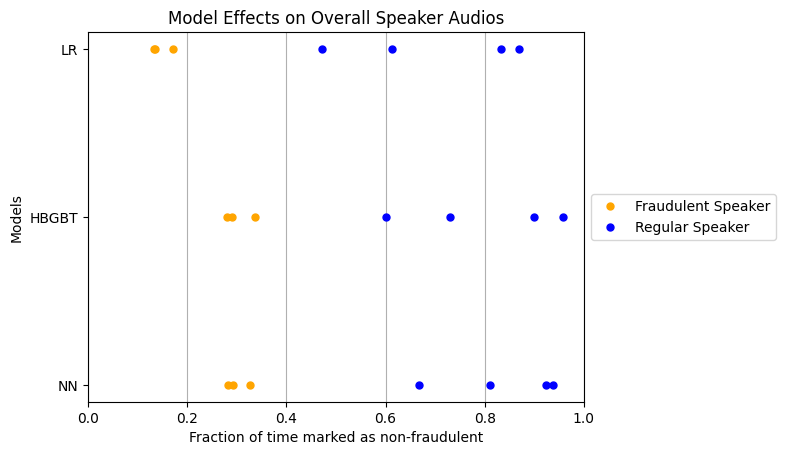

In [29]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot([0.2824, 0.2918, 0.3273, 0.2797, 0.2910, 0.3359, 0.133, 0.1351, 0.172], [0, 0, 0, 1, 1, 1, 2, 2, 2], '.', color='orange', ms=10)
ax.plot([0.6666, 0.9379, 0.9228, 0.81081, 0.7297, 0.8991, 0.9586, 0.6016, 0.6126, 0.8338, 0.8689, 0.4715], [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2], '.', color='blue', ms=10)
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(['NN', 'HBGBT', 'LR'])
ax.set_xlim(0, 1)
ax.xaxis.grid()
plt.title("Model Effects on Overall Speaker Audios")
plt.xlabel("Fraction of time marked as non-fraudulent")
plt.ylabel("Models")
plt.legend(['Fraudulent Speaker', 'Regular Speaker'], loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()